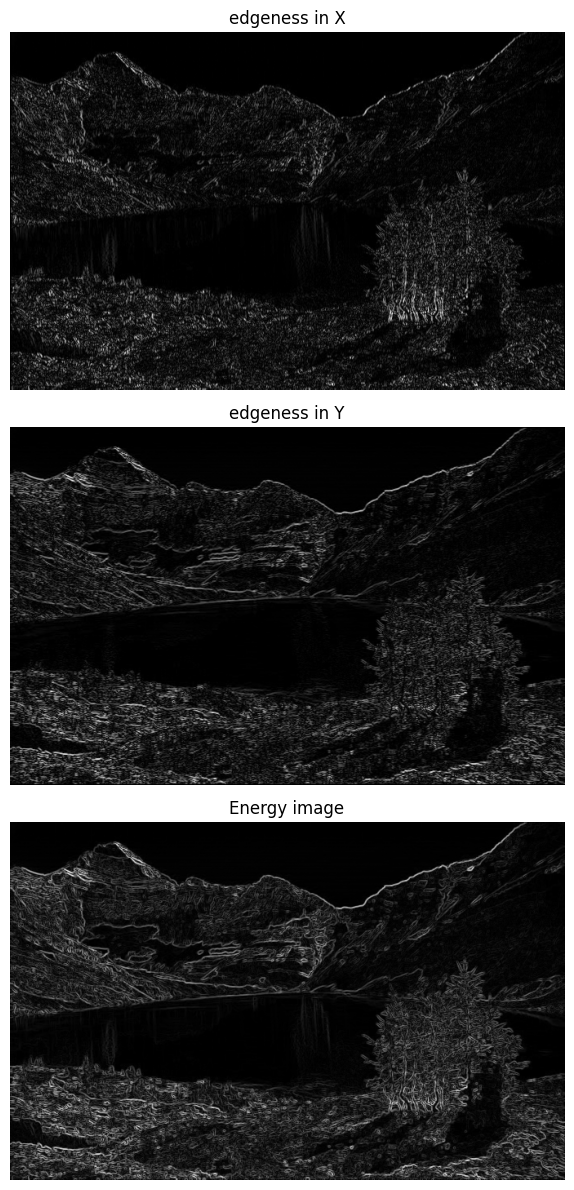

<ipython-input-66-f587ae8db8d0>:70: RuntimeWarning: overflow encountered in scalar add
  energy_map[i, j] += min(left, center, right)


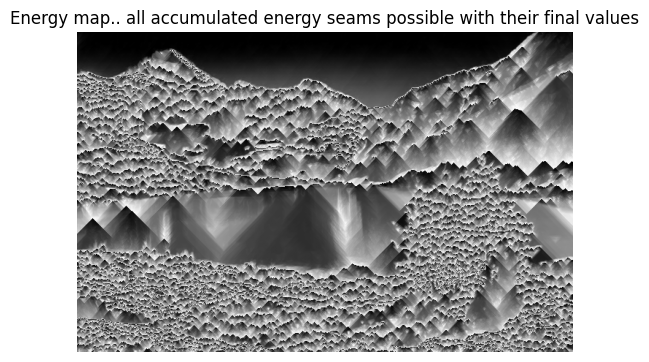

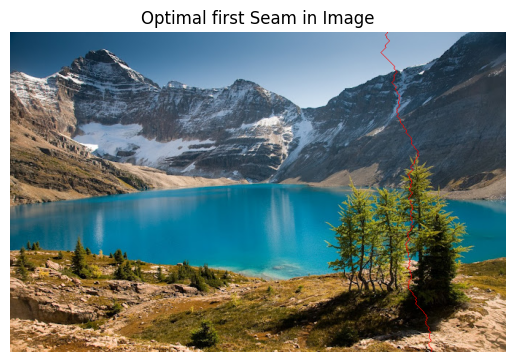

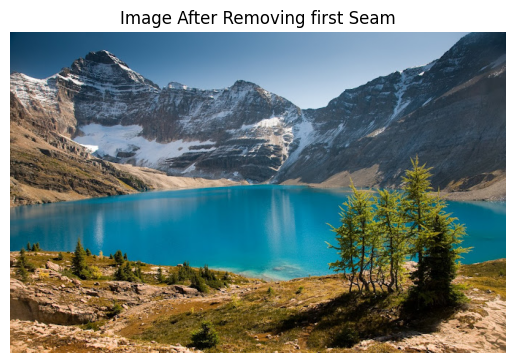

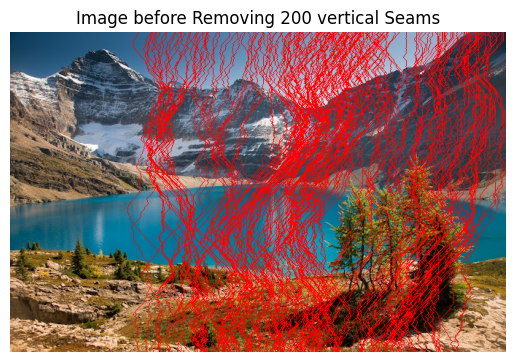

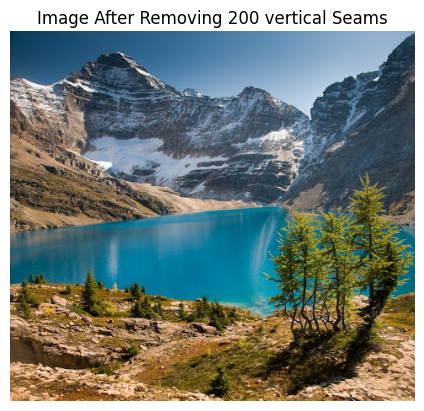

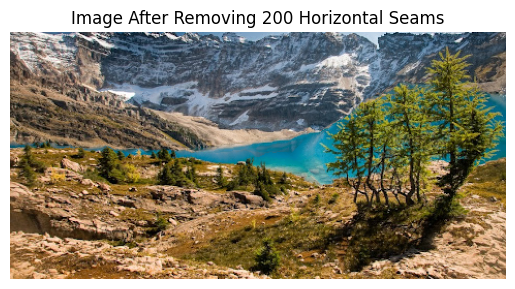

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
image_path = '/content/drive/MyDrive/Seam_Carving/lake.jpg'
image = cv2.imread(image_path)
img = image.copy()
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# Compute Sobel derivatives
Gx = cv2.Sobel(img_grey, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in X direction
Gy = cv2.Sobel(img_grey, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in Y direction
Gx = np.abs(Gx)
Gy = np.abs(Gy)
energy = np.sqrt(Gx**2 + Gy**2)
# energy_grey = cv2.cvtColor(energy, cv2.COLOR_BGR2GRAY)



# Normalize for visualization
Gx = cv2.normalize(Gx, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
Gy = cv2.normalize(Gy, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
energy = cv2.normalize(energy, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


# Display images vertically stacked
fig, axes = plt.subplots(3, 1, figsize=(6, 12))  # 3 rows, 1 column

axes[0].imshow(Gx, cmap='gray')
axes[0].set_title("edgeness in X")
axes[0].axis("off")

axes[1].imshow(Gy, cmap='gray')
axes[1].set_title("edgeness in Y")
axes[1].axis("off")

axes[2].imshow(energy, cmap='gray')
axes[2].set_title("Energy image")
axes[2].axis("off")

plt.tight_layout()
plt.show()


# a step to save the energy values in a txt file (not needed)
file_path = '/content/drive/MyDrive/Seam_Carving/Energy.txt'
# Save the pixel values
# np.savetxt(file_path, energy, fmt="%d")



# calculates all possible energy seam that can ever be found.. accumulated
# energy seams
def compute_energy_map_accumulation(energy):
    """Compute the minimum seam cost matrix using dynamic programming."""
    h, w = energy.shape
    energy_map = energy.copy()

    # Iterate from the second row to the bottom
    for i in range(1, h):
        for j in range(w):
            # Get the min cost from the row above (left, center, right)
            left = energy_map[i-1, j-1] if j > 0 else float('inf')
            center = energy_map[i-1, j]
            right = energy_map[i-1, j+1] if j < w-1 else float('inf')

            # Update the energy accumulation
            energy_map[i, j] += min(left, center, right)

    return energy_map


energy_map = compute_energy_map_accumulation(energy)

# Display energy map
plt.imshow(energy_map, cmap='gray')
plt.title("Energy map.. all accumulated energy seams possible with their final values")
plt.axis("off")
plt.show()





# find the minimum number in each row only
def find_optimal_seam(energy_map):
    """
    Backtracks from the bottom row to find the optimal seam with the lowest energy.

    Parameters:
    - energy_map: 2D numpy array, the cumulative energy map.

    Returns:
    - seam: 1D numpy array of column indices for the optimal seam.
    """



    h, w = energy_map.shape
    seam = np.zeros(h, dtype=np.int32)  # Store seam column indices

    # Step 1: Find the smallest value in the last row (lowest-energy pixel)
    seam[-1] = np.argmin(energy_map[-1])

    # Step 2: Backtrack from bottom to top
    for i in range(h-2, -1, -1):  # Start from the second last row and move up
        prev_x = seam[i+1]  # Column index of the seam pixel in the row below

        # Step 3: Choose the lowest-energy path from the row above
        min_x = max(prev_x - 1, 0)  # Left neighbor (if within bounds)
        max_x = min(prev_x + 1, w - 1)  # Right neighbor (if within bounds)

        # Extract the three neighboring values
        left_value = energy_map[i, min_x]
        center_value = energy_map[i, prev_x]
        right_value = energy_map[i, max_x]

        # Store them in a list and find the index of the minimum value
        neighbors = [left_value, center_value, right_value]
        best_index = np.argmin(neighbors)

        # Convert the relative index to an absolute column index
        seam[i] = [min_x, prev_x, max_x][best_index]

    return seam

optimal_seam = find_optimal_seam(energy_map)



# # Print seam coordinates
# print("Optimal Seam Coordinates (Row, Column):")
# for i, j in enumerate(optimal_seam):
#     print(f"Row {i}, Column {j}")



# Display the seam on the image
# image_with_seam = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
image_with_seam = img.copy()
for i, j in enumerate(optimal_seam):
    image_with_seam[i, j] = [0, 0 , 255]  # Mark seam in red

# Show the optimal seam
plt.imshow(cv2.cvtColor(image_with_seam, cv2.COLOR_BGR2RGB))
plt.title("Optimal first Seam in Image")
plt.axis("off")
plt.show()

def remove_seam(image, seam):
    """
    Removes the given seam from the image by shifting pixels.

    Parameters:
    - image: 3D numpy array (H × W × 3), the original image.
    - seam: 1D numpy array, the column indices of the seam.

    Returns:
    - new_image: Image with one column removed.
    """
    h, w, _ = image.shape  # Get dimensions
    new_image = np.zeros((h, w-1, 3), dtype=np.uint8)  # Create new image with width reduced by 1

    for i in range(h):
        col = seam[i]  # Column index of the seam in this row
        # Remove the seam pixel by shifting the rest of the row left
        new_image[i, :, :] = np.delete(image[i, :, :], col, axis=0)

    return new_image


image_resized = remove_seam(img, optimal_seam)



# Display the resized image After Removing first Seam
plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
plt.title("Image After Removing first Seam")
plt.axis("off")
plt.show()




def visualize_seam(image, seam):
    """Draws the seam on the image in red."""
    image_with_seam = image.copy()
    for i, j in enumerate(seam):
        image_with_seam[i, j] = [0, 0, 255]  # Mark seam in red (BGR)
    return image_with_seam


#removing multiple seams - vertical and horizontal seams are equal
num_seams = 200  # Number of seams to remove
# num_horizontal_seams = 200

image_with_seams = img.copy()


#loop to remove vertical seams
for _ in range(num_seams):
    # Compute energy map
    Gx = cv2.Sobel(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.CV_64F, 1, 0, ksize=3)
    Gy = cv2.Sobel(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.CV_64F, 0, 1, ksize=3)
    energy = np.abs(Gx) + np.abs(Gy)

    # Compute seam cost and find the optimal seam
    energy_map = compute_energy_map_accumulation(energy)
    optimal_seam = find_optimal_seam(energy_map)


    #visualize the seams
    image_with_seams = visualize_seam(image_with_seams, optimal_seam)


    # Remove the seam
    img = remove_seam(img, optimal_seam)



# Display the seams on image
plt.imshow(cv2.cvtColor(image_with_seams, cv2.COLOR_BGR2RGB))
plt.title(f"Image before Removing {num_seams} vertical Seams")
plt.axis("off")
plt.show()



# Display the resized image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Image After Removing {num_seams} vertical Seams")
plt.axis("off")
plt.show()




# def remove_horizontal_seams(image, num_seams):
"""Removes horizontal seams by transposing, applying vertical seam carving, and transposing back."""
img_t = np.transpose(img, (1, 0, 2))  # Transpose: (H, W, 3) → (W, H, 3)

for _ in range(num_seams):
    # Compute Energy Map (Expanded)
    gray = cv2.cvtColor(img_t, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    Gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in X direction
    Gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in Y direction
    energy = np.abs(Gx) + np.abs(Gy)  # Combine gradient magnitudes

    # Compute seam cost and find the optimal seam
    energy_map = compute_energy_map_accumulation(energy)
    optimal_seam = find_optimal_seam(energy_map)


    # Remove the seam from the transposed image
    img_t = remove_seam(img_t, optimal_seam)

img_resized = np.transpose(img_t, (1, 0, 2))  # Transpose back (W, H, 3) → (H, W, 3)
    # return img_resized



#comment this out if no need to remove horizontal seams
# final_image = remove_horizontal_seams(img, num_seams)


# Display result
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.title(f"Image After Removing {num_seams} Horizontal Seams")
plt.axis("off")
plt.show()



